<a href="https://colab.research.google.com/github/andrewcxjin/aipi590-xai/blob/main/explainable_techniques_II_Jin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Explainable Techniques II**
**Andrew Jin**

This notebook shows the production and interpretation of PDP, ICE, and ALE plots from a specific model and dataset.

Dataset: https://www.kaggle.com/datasets/vrajesh0sharma7/college-student-placement/code

This dataset focuses on factors that are believed to affect college placement outcomes. There are 10,000 data points and the target variable is placement outcome indicated with a binary variable. The definition of placement outcome is arbitary, so for this notebook we will assume that 1 indicates success in receiving a college offer while 0 represents the opposite.  



#### 📝 Note
My Colab has a built in assistant from Gemini that provided suggestions on the code. The global_explanations.ipynb notebook from the course Github page was also referenced to. I also used ChatGPT to debug my code in the "Plots" section. The markdown explanations were written in my own words with no AI assistance.

In [2]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-9s_l3tq7/alepython_19319214fb96482cb461544c44bf24ea
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-9s_l3tq7/alepython_19319214fb96482cb461544c44bf24ea
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.7 MB/s eta 0:00:00
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350ab6-py3-none-any.whl size=15251 sha256=1672d88a4606975f1250f7476748712347e99530bfdab86f2a544faf417fa77b
  Stored in directory: /tmp/pip-ephem-wheel-cache-tm92el28/wheels/87/54/8b/9357059e0e9ade0ea889a30fe56beaed44312e07475133b2cc
Successfully built alepython


In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import shap
from alepython import ale_plot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from itertools import combinations

## Exploratory Data Analysis

In [4]:
# Load dataset and preview
import kagglehub

path = kagglehub.dataset_download('vrajesh0sharma7/college-student-placement')
df = pd.read_csv(path + '/CollegePlacement.csv')
df.head()

100%|██████████| 108k/108k [00:00<00:00, 28.8MB/s]

Extracting files...


,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,CLG0030,107,6.61,6.28,8,No,8,8,4,No
1,CLG0061,97,5.52,5.37,8,No,7,8,0,No
2,CLG0036,109,5.36,5.83,9,No,3,1,1,No
3,CLG0055,122,5.47,5.75,6,Yes,1,6,1,No
4,CLG0004,96,7.91,7.69,7,No,8,10,2,No


In [5]:
# Explore data structure
print('Data structure of dataframe')
for column in df.columns:
  print(f'Column Name: {column}, Data Type: {df[column].dtypes}')

Data structure of dataframe
Column Name: College_ID, Data Type: object
Column Name: IQ, Data Type: int64
Column Name: Prev_Sem_Result, Data Type: float64
Column Name: CGPA, Data Type: float64
Column Name: Academic_Performance, Data Type: int64
Column Name: Internship_Experience, Data Type: object
Column Name: Extra_Curricular_Score, Data Type: int64
Column Name: Communication_Skills, Data Type: int64
Column Name: Projects_Completed, Data Type: int64
Column Name: Placement, Data Type: object


In [6]:
# Check for missing values
print('Null values in dataset')
null_counts = df.isnull().mean()
print(null_counts)

Null values in dataset
College_ID                0.0
IQ                        0.0
Prev_Sem_Result           0.0
CGPA                      0.0
Academic_Performance      0.0
Internship_Experience     0.0
Extra_Curricular_Score    0.0
Communication_Skills      0.0
Projects_Completed        0.0
Placement                 0.0
dtype: float64


In [7]:
# Drop ID column as it is irrelevant for EDA
df = df.drop(columns='College_ID')

# Change yes/no columns to binary
df['Placement'] = df['Placement'].replace({'Yes': 1, 'No':0})
df['Internship_Experience'] = df['Internship_Experience'].replace({'Yes': 1, 'No': 0})
df.head()

/tmp/ipython-input-1456323600.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Placement'] = df['Placement'].replace({'Yes': 1, 'No':0})
/tmp/ipython-input-1456323600.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Internship_Experience'] = df['Internship_Experience'].replace({'Yes': 1, 'No': 0})


,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,107,6.61,6.28,8,0,8,8,4,0
1,97,5.52,5.37,8,0,7,8,0,0
2,109,5.36,5.83,9,0,3,1,1,0
3,122,5.47,5.75,6,1,1,6,1,0
4,96,7.91,7.69,7,0,8,10,2,0


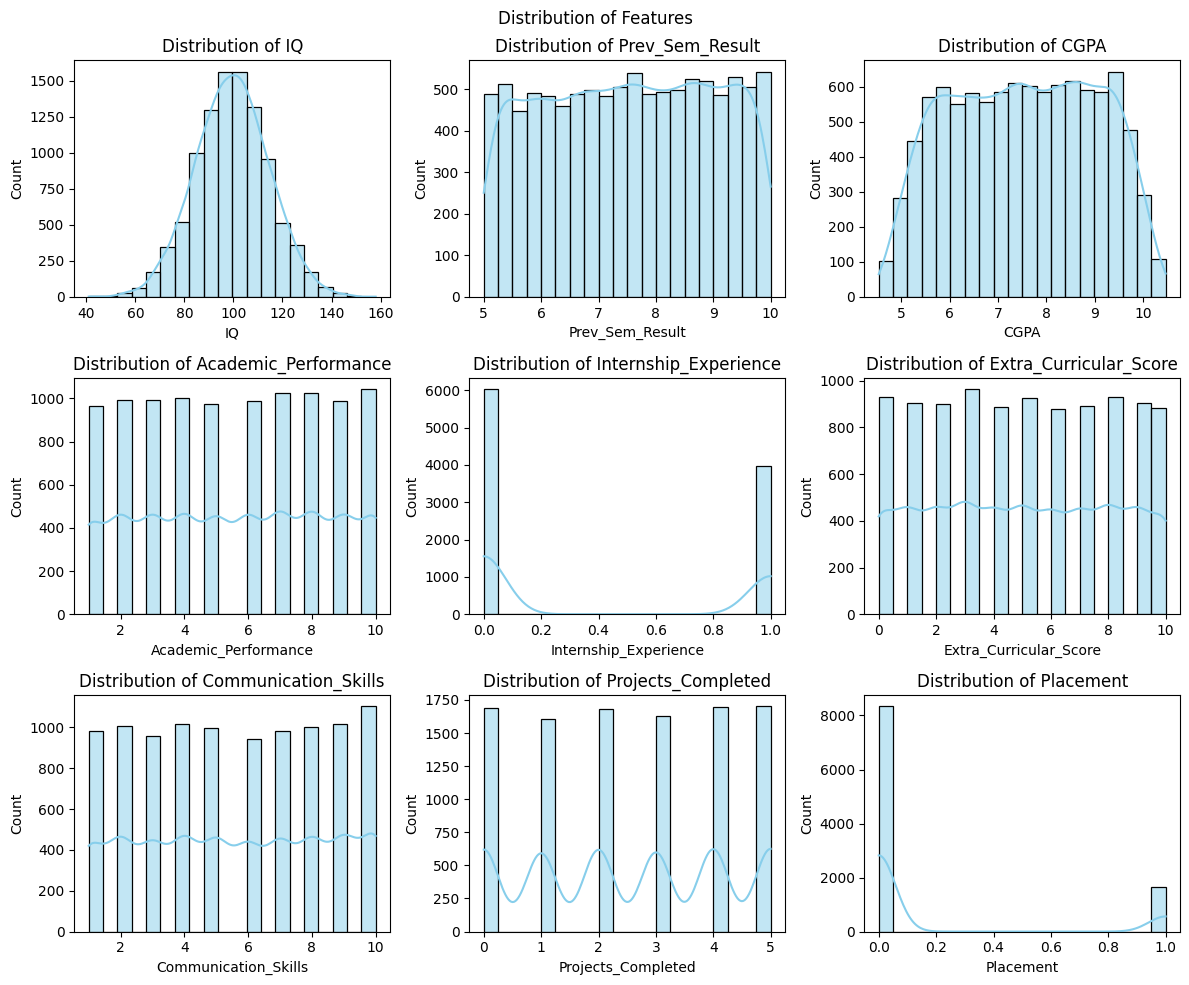

In [6]:
# Visualize distribution of features
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(df.columns):
  sns.histplot(df[col], kde=True, bins=20, ax=axes[i], color='skyblue', edgecolor='black')
  axes[i].set_title(f'Distribution of {col}')

plt.suptitle('Distribution of Features')
plt.tight_layout()
plt.show()

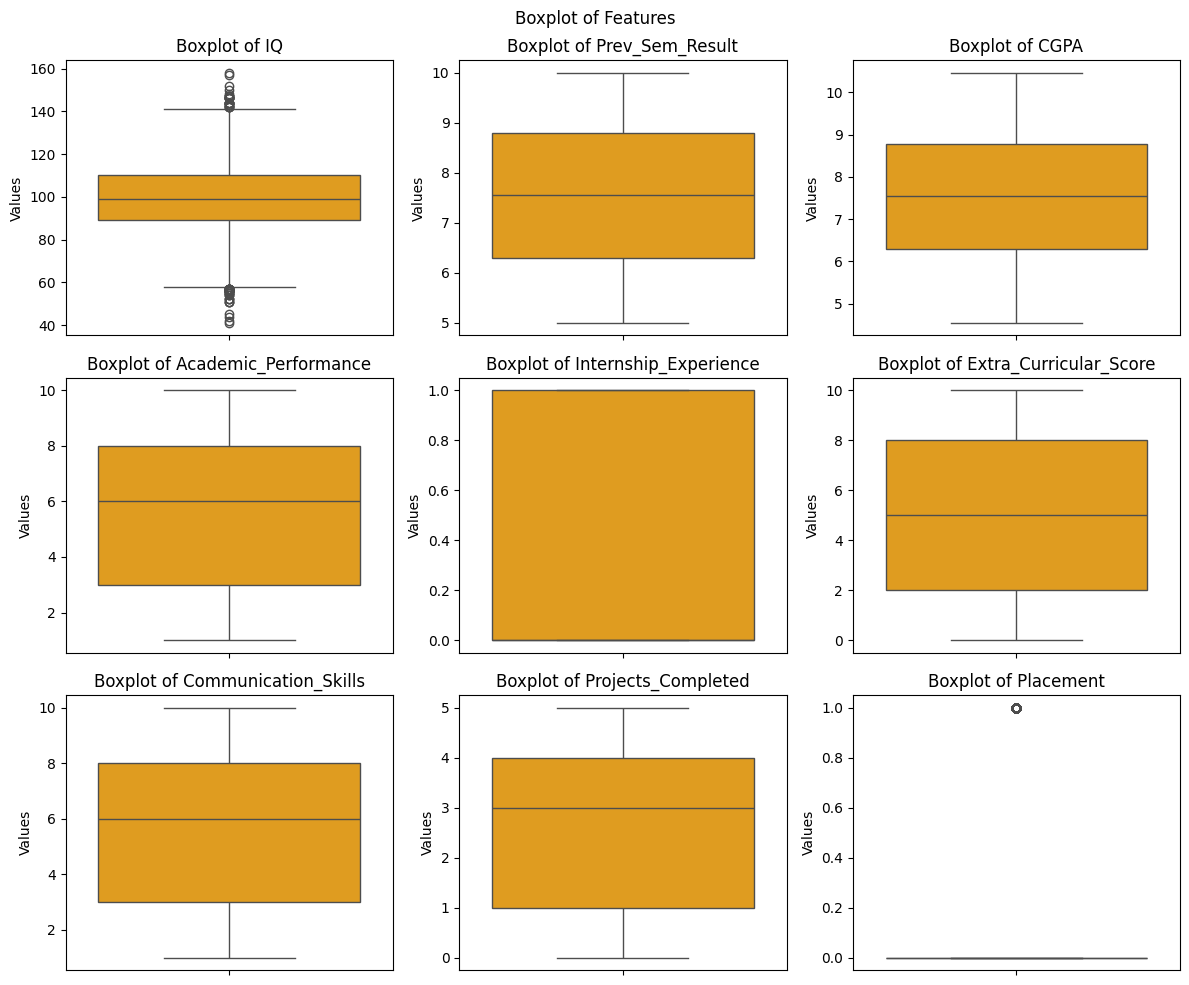

Outliers in IQ: 61
Outliers in Prev_Sem_Result: 0
Outliers in CGPA: 0
Outliers in Academic_Performance: 0
Outliers in Internship_Experience: 0
Outliers in Extra_Curricular_Score: 0
Outliers in Communication_Skills: 0
Outliers in Projects_Completed: 0
Outliers in Placement: 1659


In [7]:
# Visualize boxplot of features
fig, axes = plt.subplots(3, 3, figsize=(12,10))
axes = axes.flatten()

for i, col in enumerate(df.columns):
  sns.boxplot(data=df, y=col, ax=axes[i], color='orange')
  axes[i].set_title(f'Boxplot of {col}')
  axes[i].set_ylabel('Values')

plt.suptitle('Boxplot of Features')
plt.tight_layout()
plt.show()

# Outlier detection
for col in df.columns:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
  [print(f'Outliers in {col}:', outliers.shape[0])]

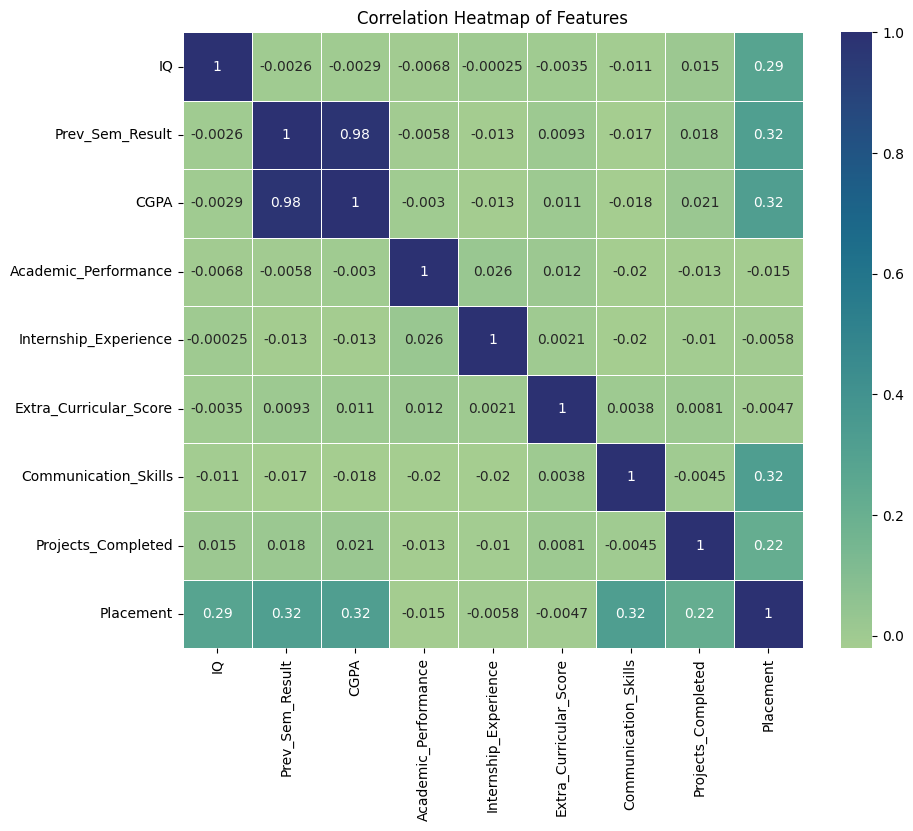

In [8]:
# Visualize heatmap of features
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='crest', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

From the EDA, we can see that there are no missing values. There were some categorical features but they consisted of 'yes' or 'no' so I was able to numericalize this by mapping it to 1 and 0 repspectively. Other than IQ, we can see that the other features have a relativley uniform distribution. From the boxplots we can see that both IQ and Placement have several outliers. The IQ distribution follows a normal distribution so it does make sense that there may be outliers at the far end of the distribution. The outliers in Placement could indicate that there is a high class imbalance, which we can see from the distribution plot. From the heatmap, we can see that the majority of features don't have a strong correlation with each other. The cumulative GPA and previous semester result have a high correlation of 0.98 which makes sense as GPA is dependent on each semester's performance.

## Model and Training

As mentioned earlier, the dataset used analyzes different factors that may affect a college student's placement. For the model, I will use an XGBoost classifier with default paramters. I will do a 70/30 stratified train/test split to account for the class imbalance in our target variable.

In [8]:
# Load data and split
X = df.drop(columns='Placement')
y = df['Placement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Train model and generate predictions
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate performance
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[2500    2]
 [   3  495]]


## Plots

### Partial Dependence Plots (PDP) & ICE Plots

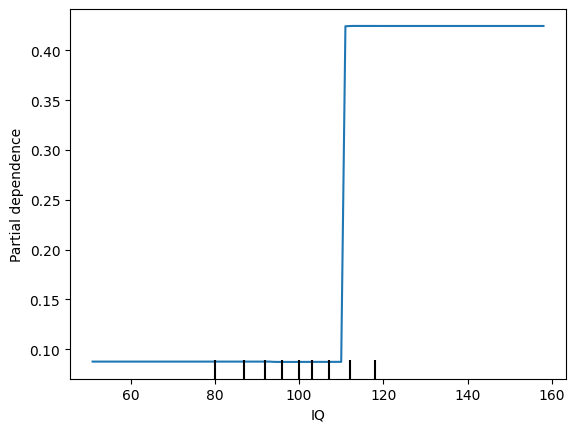

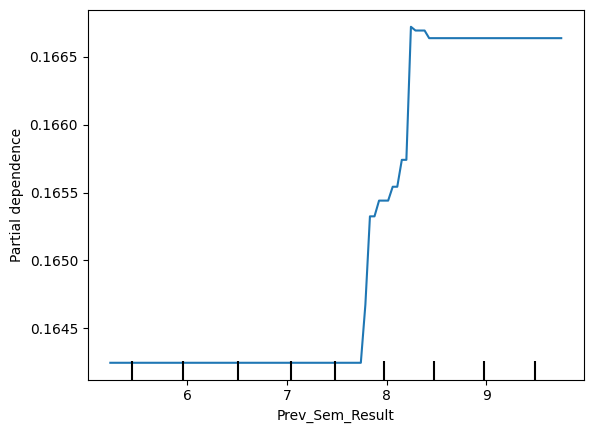

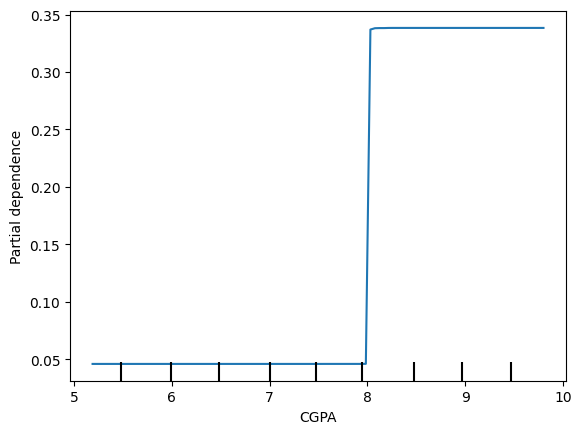

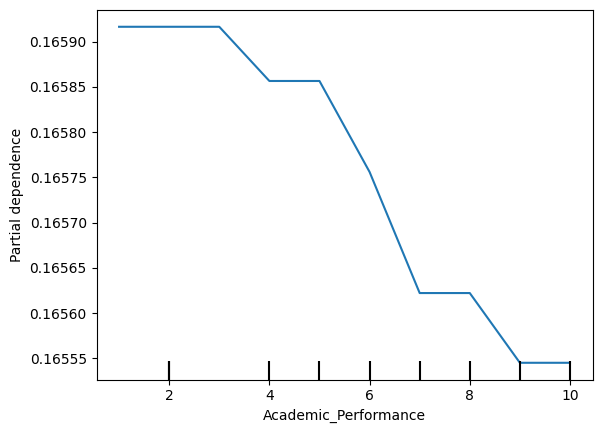

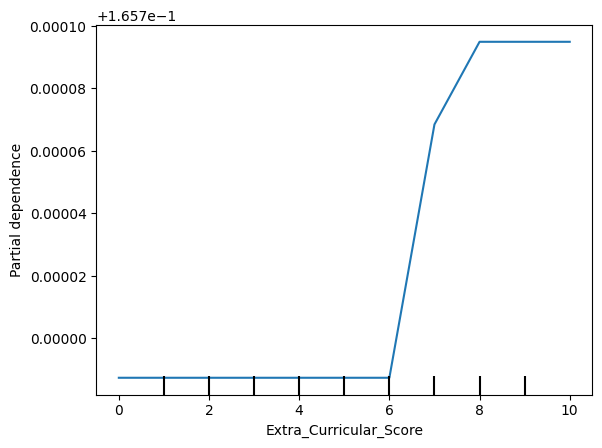

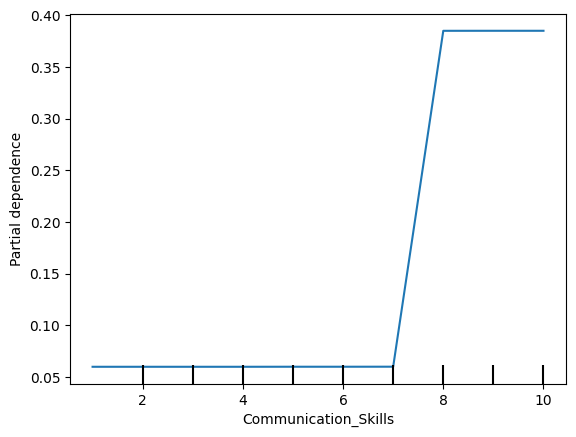

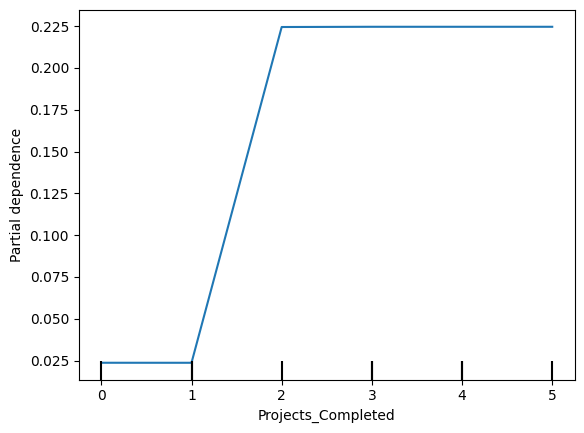

In [67]:
# PDP Plots
for col in X_test.columns:
    if X_test[col].nunique() > 2:  # we skip binary features as it creates error
        PartialDependenceDisplay.from_estimator(model, X_test, [col], kind='average')

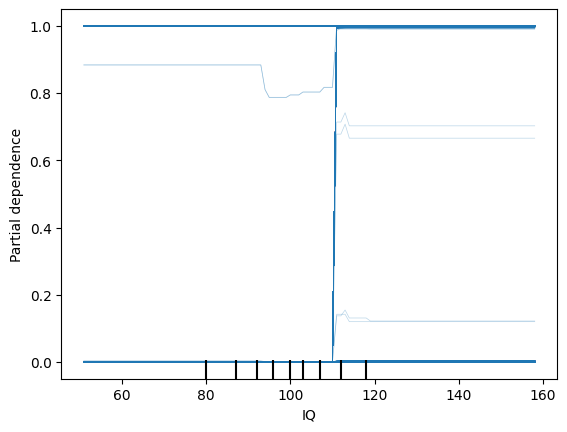

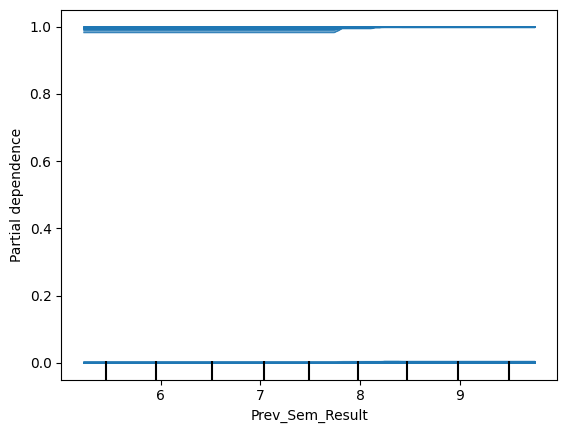

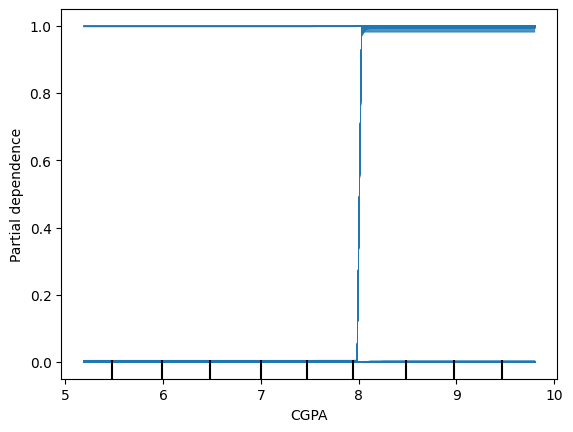

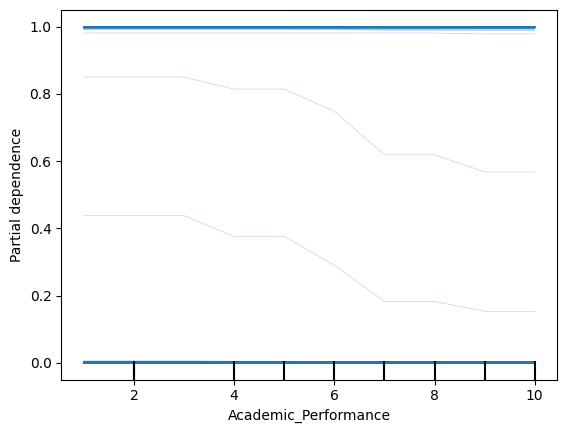

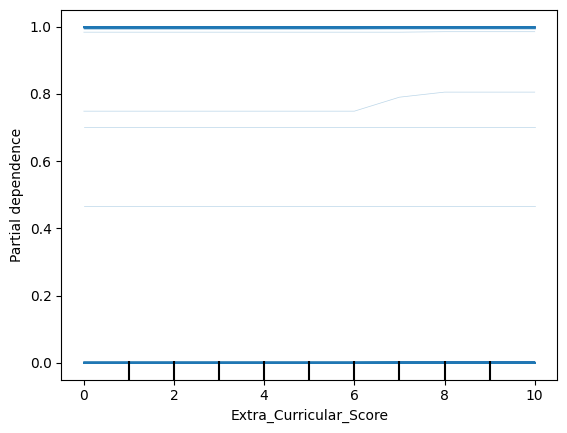

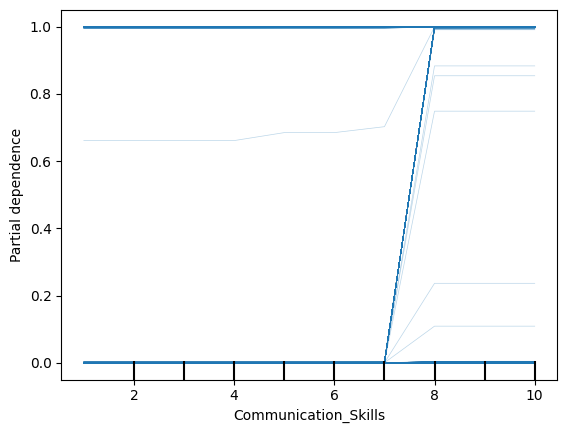

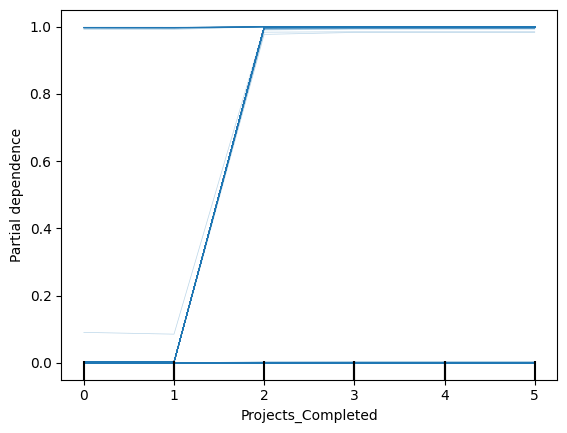

In [69]:
# ICE Plots
for col in X_test.columns:
    if X_test[col].nunique() > 2:  # we skip binary features as it creates error
        PartialDependenceDisplay.from_estimator(model, X_test, [col], kind='individual')

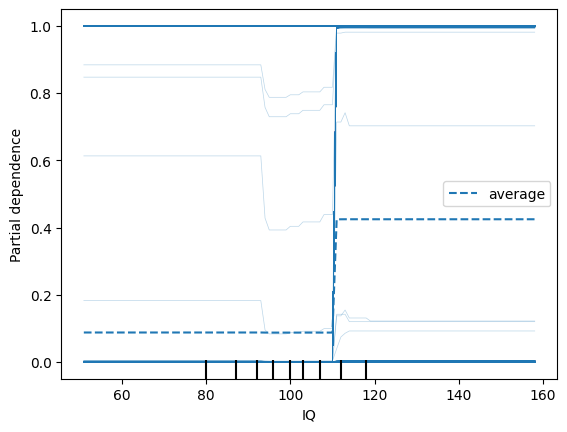

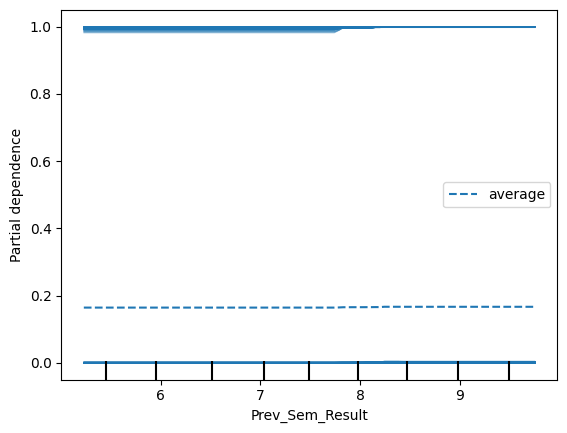

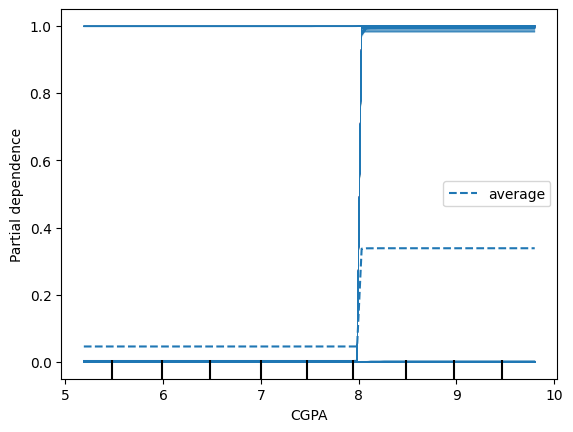

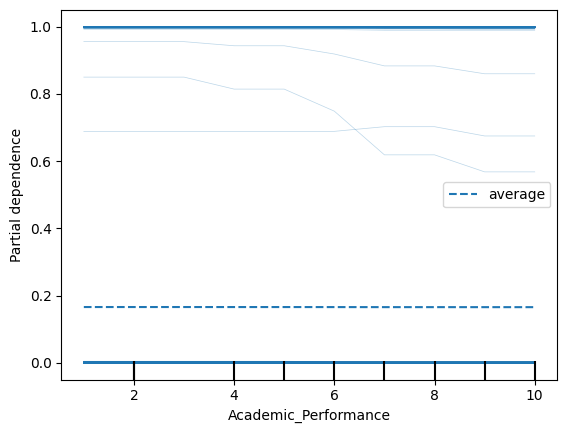

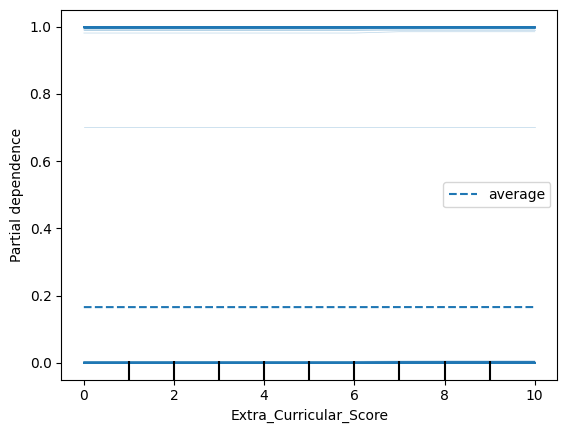

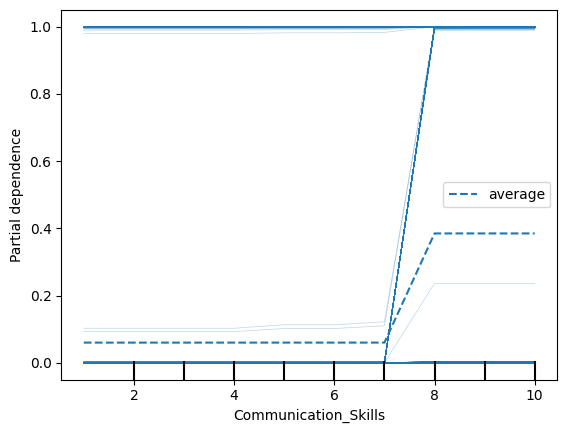

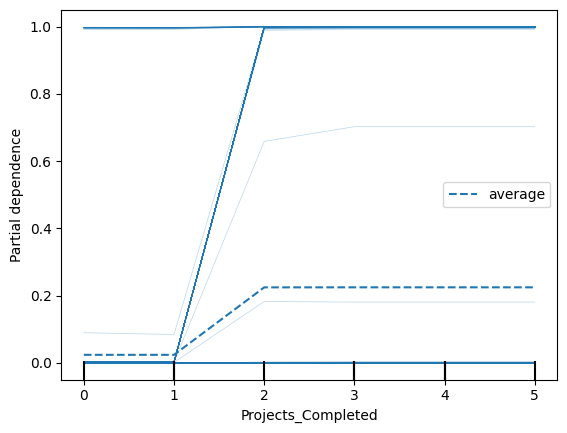

In [72]:
# Both PDP and ICE
for col in X_test.columns:
    if X_test[col].nunique() > 2:  # we skip binary features as it creates error
        PartialDependenceDisplay.from_estimator(model, X_test, [col], kind='both')

I have plotted the PDP, ICE Plots, and also showed graphs with both of them plotted together for comparison. If we look at the PDP plots, we can see that generally increasing the value of one feature will increase the prediction. One feature has the opposite trend: Academic Performance. However, if we look closely at the partial dependence value, we see that the difference between the minimum and maximum is 0.00035 which is essentially negligble. This indicates that Academic Performance doesn't contribute much to the prediction which make sense as many colleges have moved away from the traditional approach of evaluating an applicant based on their report card. The features that seem to contribute to the overall predictions are IQ and CGPA. This somehow contradicts the Academic Performance trend as we would expect CGPA and Academic Performance to correlate with each other. This could indicate that the collages emphasize CGPA more has it is a number that is easy to understand and quantifies academic performance to a certain extent.

If we look at the ICE plots, most of the features have similar lines indicating that the feature has a consistent effect across all samples. Some features that seem to have noticeable different lines are IQ, Communication Skills, and Projects Completed. It would make sense that there is some variability in how these features affect the prediction as no college has a "golden" threshold for these features. This indicates that colleges review application on a case-by-case basis. A low IQ wouldn't necessarily disqualify an applicant if they have other outstanding traits, which is this feature may have variability in the lines of the ICE plot.

When we plot PDP and ICE together we can observe whether the feature effect is consistant across individual cases. If the ICE lines are clustered tightly around the PDP (average) line, then this would indicate that the feature's effect is stable across each individual. We, however, observe the opposite. Such patterns indicates that the features interact differently with each other so it depends on each individual case. This further supports our claim of colleges evaluating applcations on a case-by-case basis.

### ALE Plots

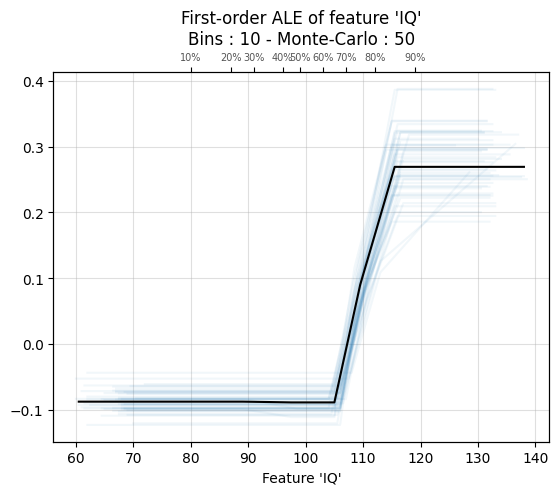

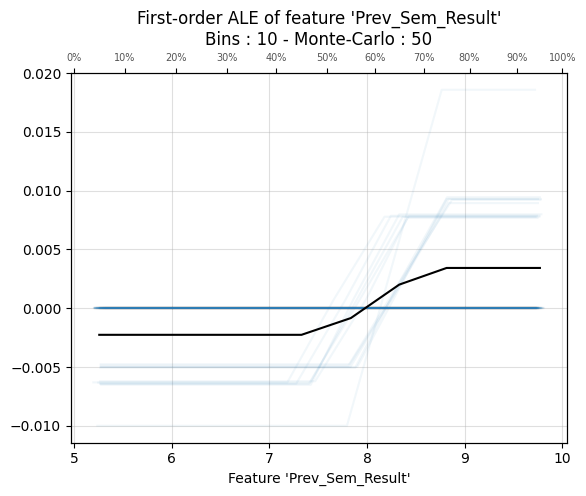

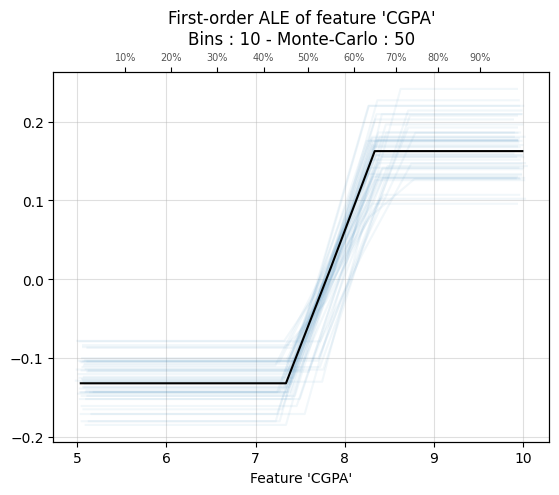

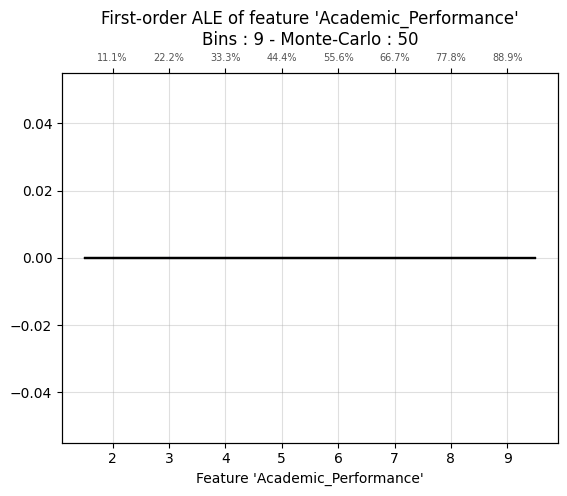

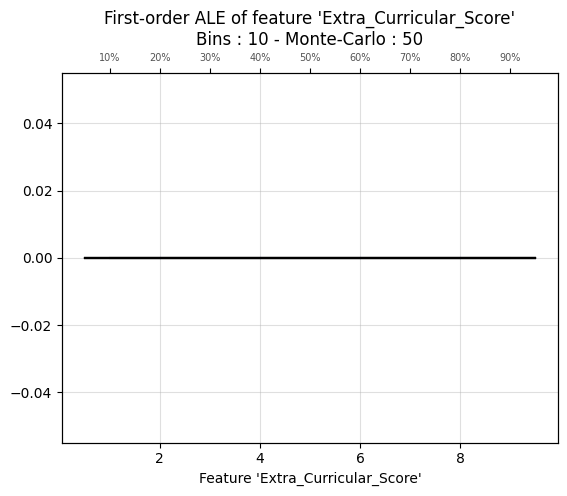

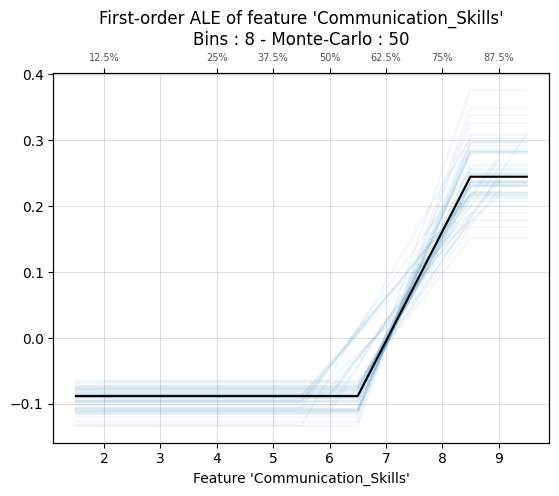

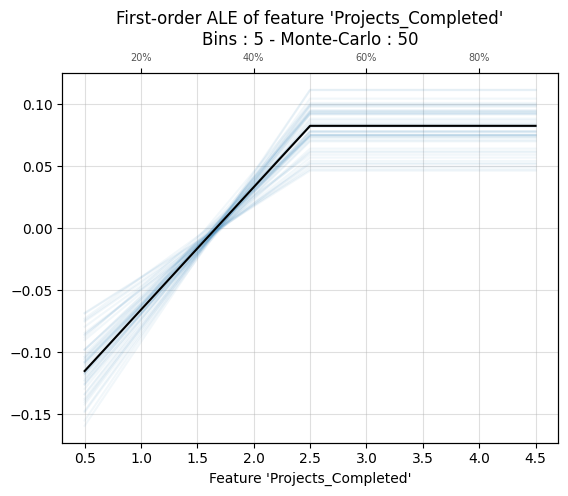

In [9]:
# 1D main effect ALE plots
for col in X_train.columns:
  if X_train[col].nunique() > 2:  # we skip binary features again
    ale_plot(model, X_train, col, monte_carlo=True)

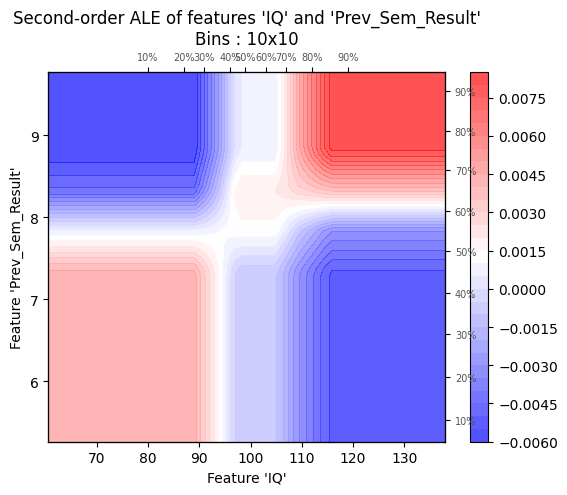

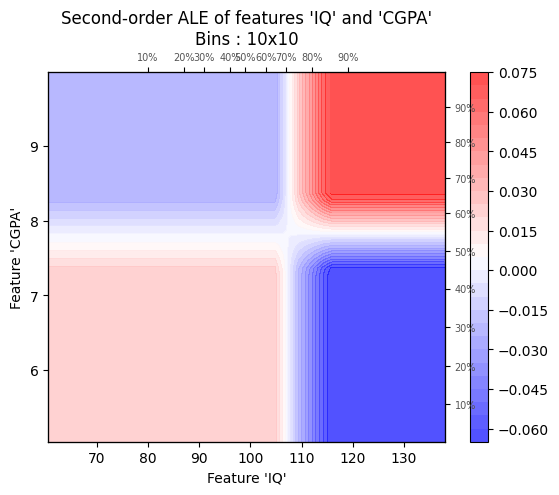

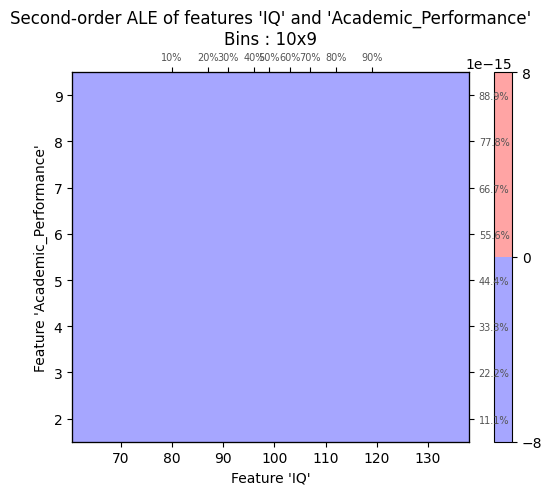

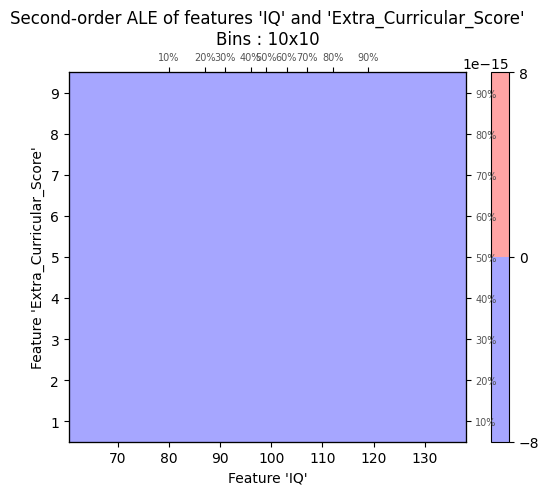

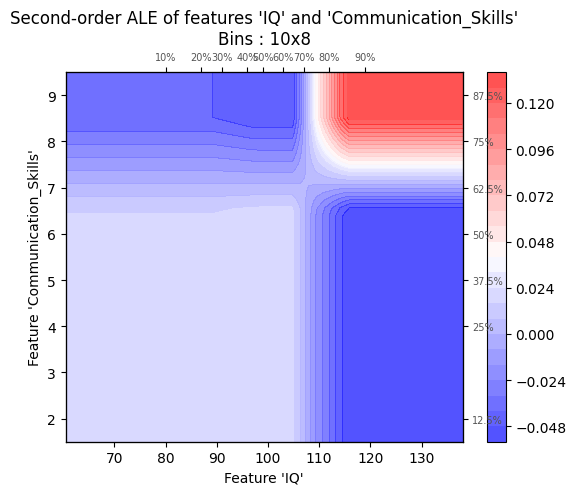

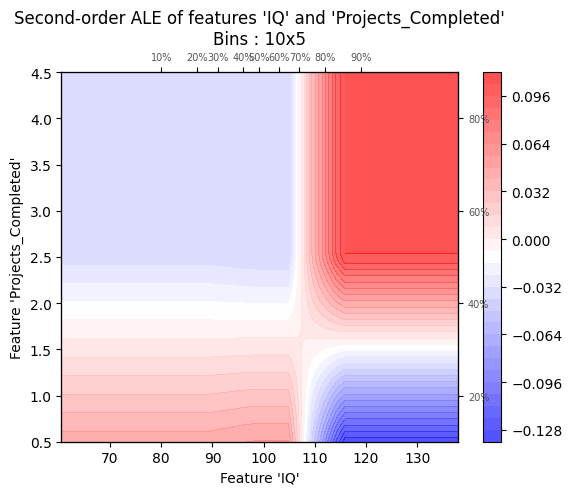

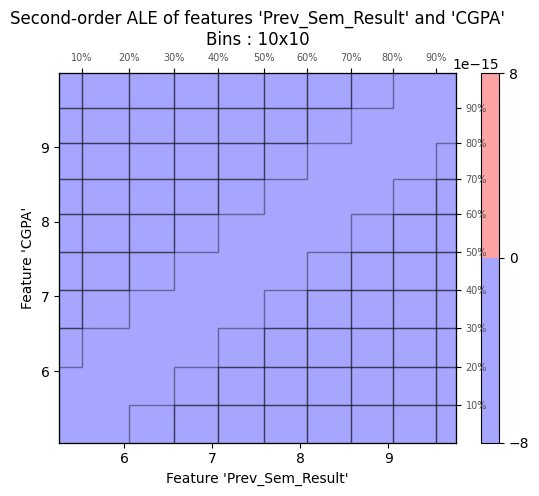

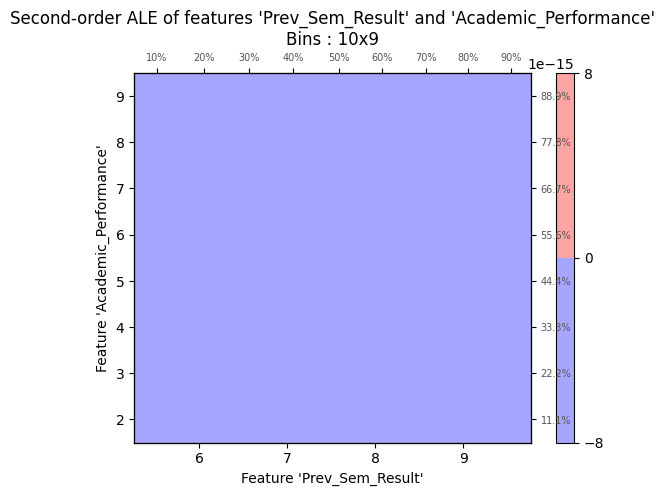

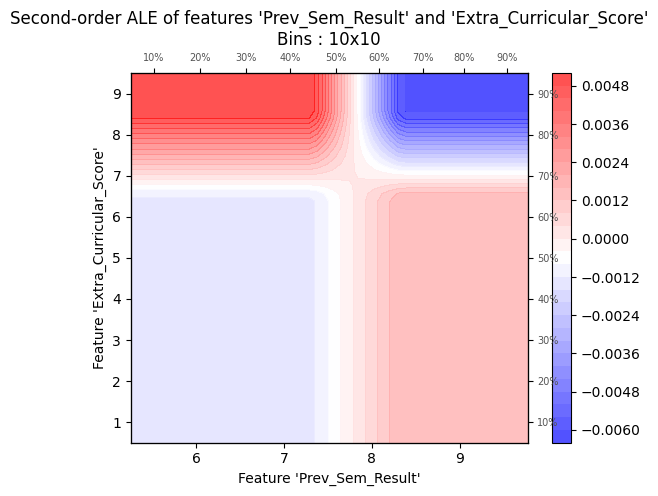

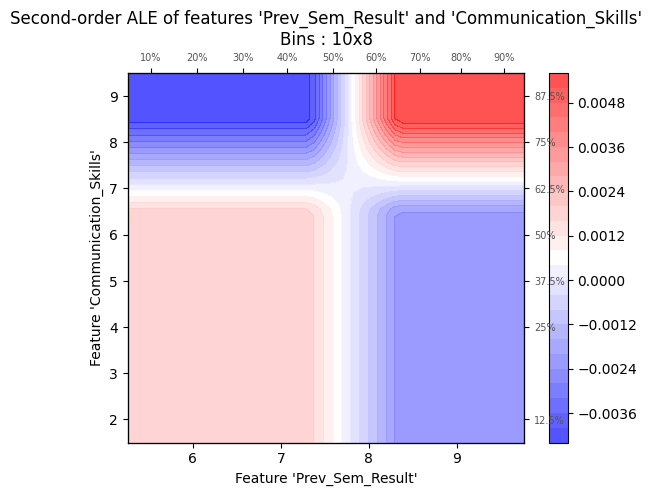

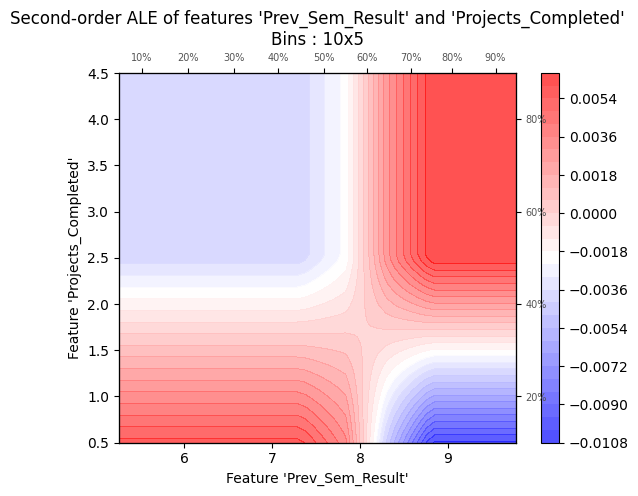

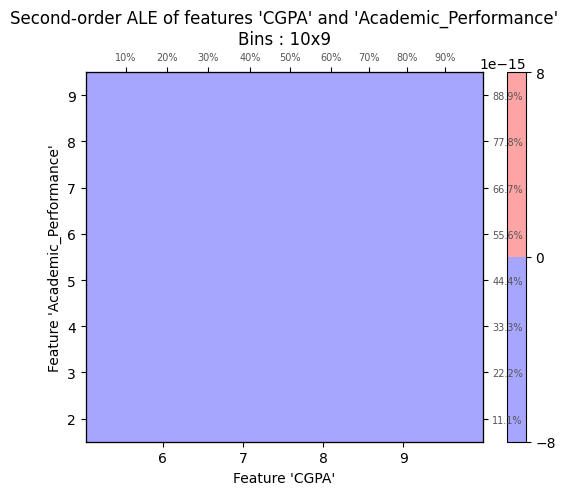

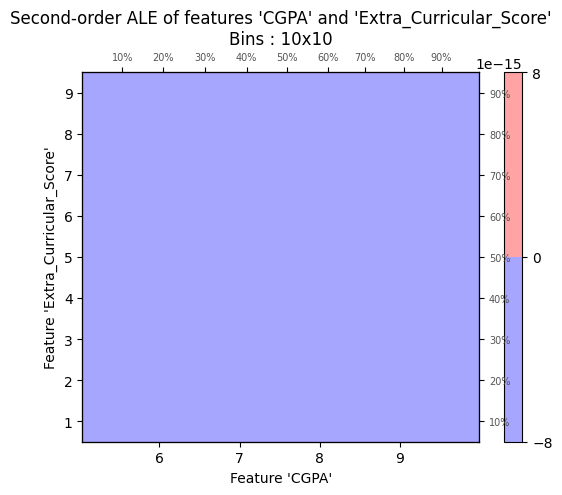

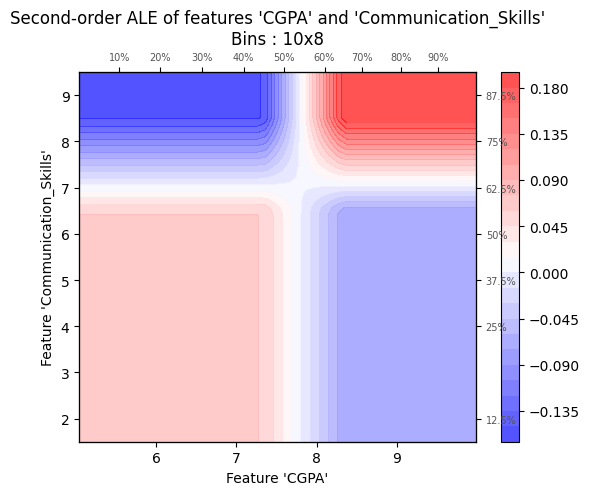

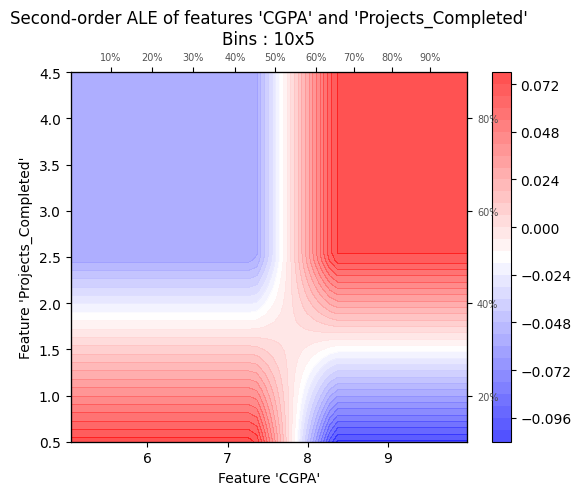

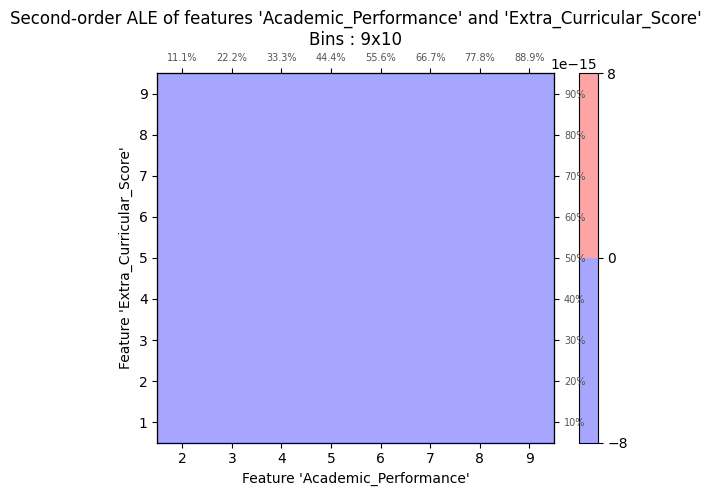

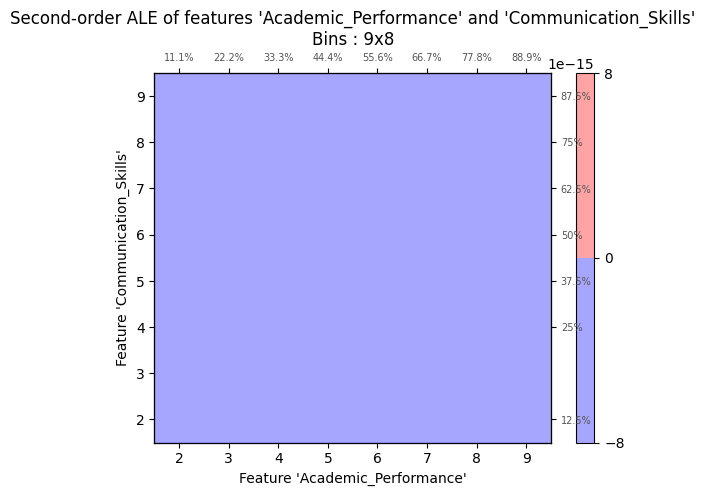

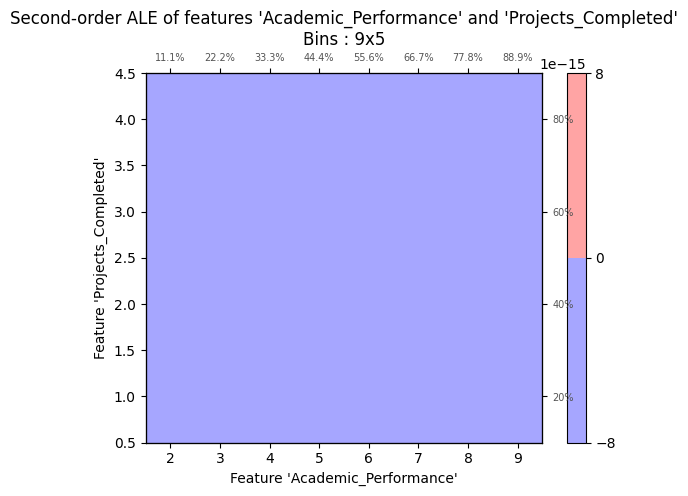

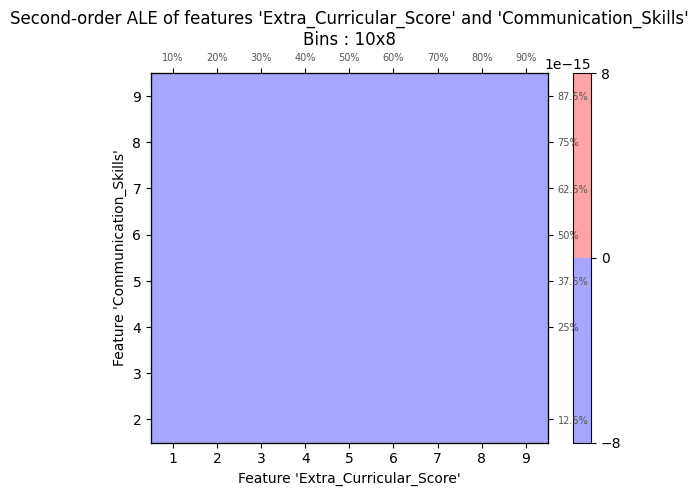

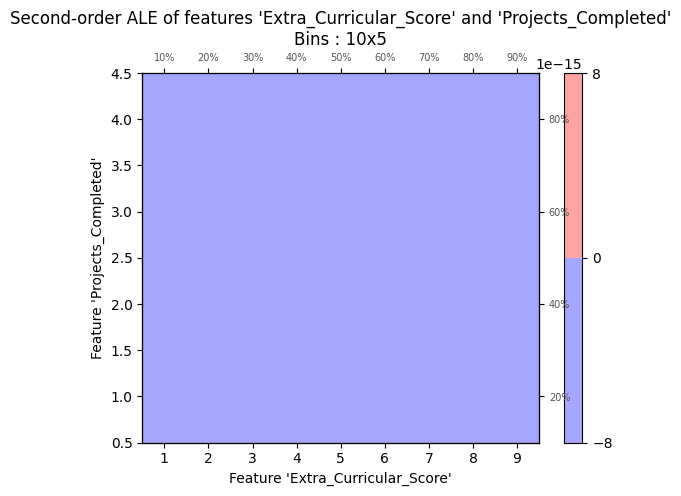

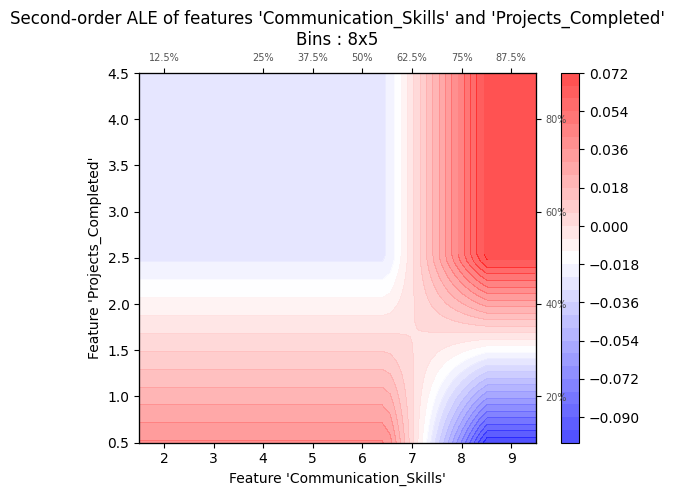

In [15]:
# 2D second-order ALE
for feat1, feat2 in combinations(X_train.columns, 2):
  if X_train[feat1].nunique() > 2 and X_train[feat2].nunique() > 2: # we skip binary features again
    ale_plot(model, X_train, [feat1, feat2], bins=10)

If we look at the 1D ALE plots, we can see that most of the features have a trend where the prediction probability increase as the feature value increases. Some features such as Academic Performance and Extra Curricular Score have a flat line, indicating that the feature has litte effect. If we compared this to the PDPs, we also see that these features have a very small difference in their maximum and minimum probability value on their respective plots.

The 2D ALE plots helps us compare two features against each other. Some plots show one solid color which indicates there are no interactions between the two features. For example, IQ and Extra Curricular Score have no interaction which makes sense because one would most likley choose their extra curricular based on their preferences and hobbies, not their IQ. Other pairs of features have varying interactions with each other, with some having a strong interaction while others have smaller effects. For instance, between IQ and CGPA, we see a strong slope near high values of both features which indicates a strong interaction. This makes sense because the higher one's IQ is, the higher their CGPA is more likely to be. These two features, however, show more shallow slopes at lower values which could indicate that there is little interaction meaning that a low IQ may not neccassarily indicate a low CGPA.